# 5 AutoEncoder

In [2]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self,input_dim=28*28,hidden_size=128, bottleneck_size=32,
                 encoder_act=nn.ReLU, decoder_act=nn.ReLU, output_act=nn.Sigmoid):
        super(AutoEncoder,self).__init__()
        self.input_dim = input_dim
        self.encoder = nn.Sequential(nn.Linear(self.input_dim,hidden_size), #28*28 as MNIST image is 28pixels wide&also tall
                                    encoder_act(),
                                    nn.Linear(hidden_size, bottleneck_size),
                                    encoder_act() )
        
        self.decoder = nn.Sequential( nn.Linear(bottleneck_size, hidden_size),
                                     decoder_act(),
                                    nn.Linear(hidden_size, self.input_dim),
                                    output_act() )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_set = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_data = [(img, label) for img, label in train_set if label == 8] #my rollno=2022102068
train_imgs = torch.stack([img for img, _ in train_data])  
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

autoencoder = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

#training
num_epochs = 10
autoencoder.train()

for epoch in range(num_epochs):
    total_loss = 0 

    for images in train_loader:
        images = images.view(images.size(0), -1) 
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.0869
Epoch [2/10], Loss: 0.0500
Epoch [3/10], Loss: 0.0418
Epoch [4/10], Loss: 0.0362
Epoch [5/10], Loss: 0.0322
Epoch [6/10], Loss: 0.0292
Epoch [7/10], Loss: 0.0270
Epoch [8/10], Loss: 0.0248
Epoch [9/10], Loss: 0.0234
Epoch [10/10], Loss: 0.0223


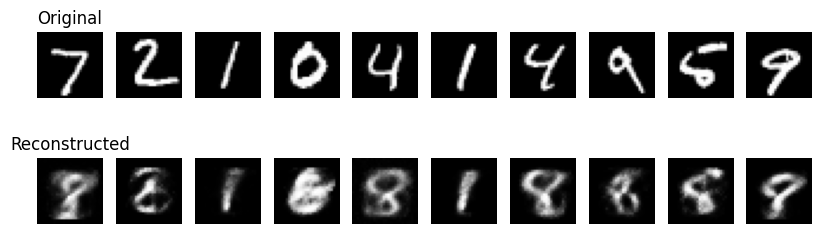

In [29]:
autoencoder.eval()

test_images, _ = next(iter(test_loader))
test_images = test_images.view(test_images.size(0), -1) 

with torch.no_grad():
    reconstructed = autoencoder(test_images)

test_images = test_images.view(-1, 28, 28).cpu().numpy()
reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

# Plot 
fig, axes = plt.subplots(2, 10, figsize=(10, 3))

for i in range(10):
    axes[0, i].imshow(test_images[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed[i], cmap="gray")
    axes[1, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.show()

In [15]:
autoencoder.eval()  

test_loss = 0
correct_predictions = 0
total_samples = 0

with torch.no_grad():  
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)  
        outputs = autoencoder(images)

        # reconstruction error
        loss = criterion(outputs, images)
        test_loss += loss.item()  

       
        error_per_image = torch.mean((outputs - images) ** 2, dim=1)  
        threshold = 0.03  

        predicted_normal = error_per_image < threshold
        actual_normal = labels == 8  

        correct_predictions += (predicted_normal == actual_normal).sum().item()
        total_samples += labels.size(0)

#Final Loss & Accuracy
test_loss /= len(test_loader)
accuracy = correct_predictions / total_samples

print(f"Test Loss: {test_loss:.4f}")
print(f"Anomaly Detection Accuracy: {accuracy:.4f}")

Test Loss: 0.0453
Anomaly Detection Accuracy: 0.8271


Text(0.5, 1.0, 'Anomalous Digits Reconstruction Error')

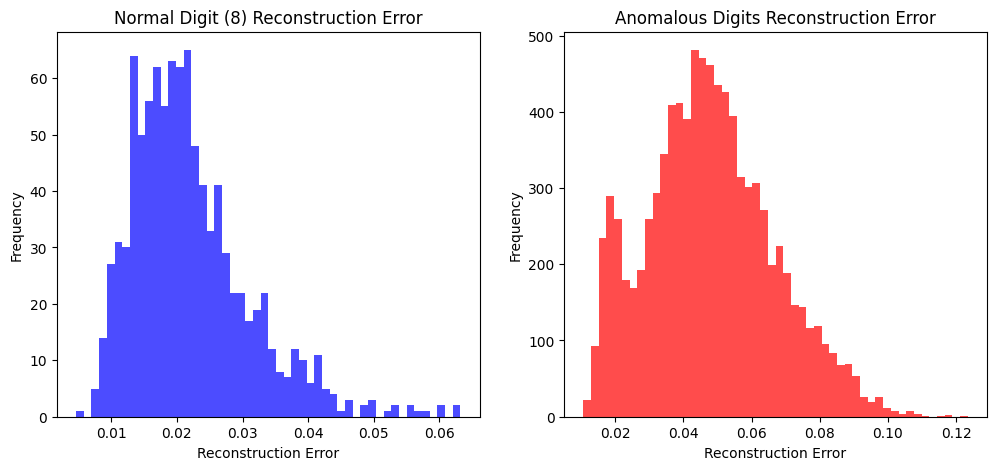

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def anomalies_det(autoencoder, test_loader):
    autoencoder.eval()
    labels = []
    errors = []

    with torch.no_grad():
        for images, label in test_loader:
            images = images.view(images.size(0), -1)
            output = autoencoder(images)
            error = torch.mean((images - output) ** 2, dim=1)  
            labels.extend(label.tolist())  
            errors.extend(error.numpy()) 

    return np.array(labels), np.array(errors)

labels, errors = anomalies_det(autoencoder, test_loader)

normal_d = 8
normal_errors = errors[labels == normal_d]
anomalous_errors = errors[labels != normal_d]

plt.figure(figsize=(12, 5))

# Plot-normal digit (8)
plt.subplot(1, 2, 1)
plt.hist(normal_errors, bins=50, alpha=0.7, color='blue')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Normal Digit (8) Reconstruction Error")

# Plot -anomalous digits
plt.subplot(1, 2, 2)
plt.hist(anomalous_errors, bins=50, alpha=0.7, color='red')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Anomalous Digits Reconstruction Error")


In [25]:
# 95th percentile as threshold
labels, errors = anomalies_det(autoencoder, test_loader)

normal_digit = 8
normal_errors = errors[labels == normal_digit]  
threshold = np.percentile(normal_errors, 95) 
print("Threshold value:", threshold) 
predictions = ["Normal" if err < threshold else "Anomalous" for err in errors]

# Sample Predictions
print("Sample Predictions:")
for lbl, pred in zip(labels[:10], predictions[:10]):
    print(f"True Digit: {lbl}, Prediction: {pred}")


Threshold value: 0.039542579650878894
Sample Predictions:
True Digit: 7, Prediction: Anomalous
True Digit: 2, Prediction: Anomalous
True Digit: 1, Prediction: Normal
True Digit: 0, Prediction: Anomalous
True Digit: 4, Prediction: Anomalous
True Digit: 1, Prediction: Normal
True Digit: 4, Prediction: Anomalous
True Digit: 9, Prediction: Anomalous
True Digit: 5, Prediction: Anomalous
True Digit: 9, Prediction: Anomalous


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
labels, errors = anomalies_det(autoencoder, test_loader)

def evaluate(labels,errors,normal=8):
    threshold = np.percentile(errors[labels==normal],95)

    predictions = (errors > threshold).astype(int)
    true_labels = (labels!=normal).astype(int)

    precision = precision_score(true_labels,predictions)
    recall = recall_score(true_labels,predictions)
    f1 = f1_score(true_labels,predictions)

    print(f"Precision: {precision:}")
    print(f"Recall: {recall:}")
    print(f"F1-score: {f1:}")

evaluate(np.array(labels), np.array(errors))

Precision: 0.9918428500083236
Recall: 0.66009306448039
F1-score: 0.7926561564557972


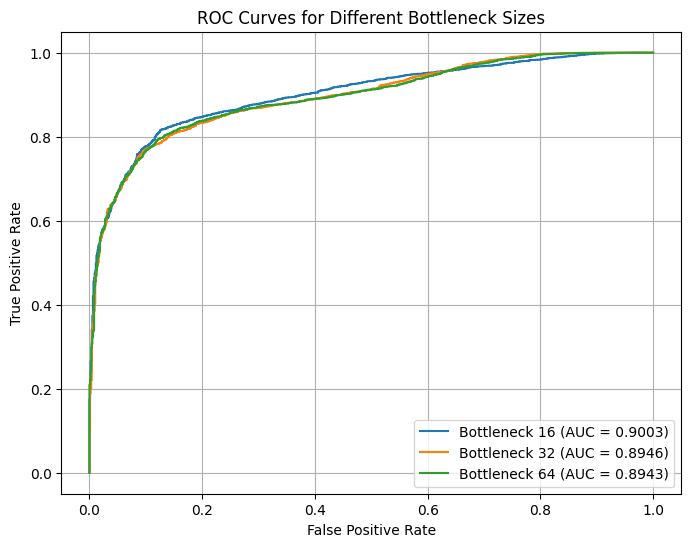

Bottleneck Size: 16, AUC-ROC Score: 0.9003
Bottleneck Size: 32, AUC-ROC Score: 0.8946
Bottleneck Size: 64, AUC-ROC Score: 0.8943


In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

labels, errors = anomalies_det(autoencoder, test_loader)
def hyp_tuning(autoencoder, test_loader, normal_digit=8):
    autoencoder.eval()
    labels = []
    errors = []

    with torch.no_grad():
        for images, label in test_loader:
            images = images.view(images.size(0), -1)
            output = autoencoder(images)
            error = torch.mean((images - output) ** 2, dim=1)
            labels.extend(label.tolist())
            errors.extend(error.numpy())

    labels = np.array(labels)
    errors = np.array(errors)

    true_labels = (labels != normal_digit).astype(int)

    auc_score = roc_auc_score(true_labels, errors)

    fpr, tpr, _ = roc_curve(true_labels, errors)

    return auc_score, fpr, tpr

#bottleneck sizes
bottleneck_sizes = [16, 32, 64]
auc_scores = {}

plt.figure(figsize=(8, 6))

for bottleneck_size in bottleneck_sizes:
    autoencoder = AutoEncoder(bottleneck_size=bottleneck_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
        for images in train_loader:
            images = images.view(images.size(0), -1) 
            
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
    
    # AUC-ROC
    auc_score, fpr, tpr = hyp_tuning(autoencoder, test_loader)
    auc_scores[bottleneck_size] = auc_score

    plt.plot(fpr, tpr, label=f"Bottleneck {bottleneck_size} (AUC = {auc_score:.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Bottleneck Sizes")
plt.legend()
plt.grid()
plt.show()

# AUC Scores
for size, auc in auc_scores.items():
    print(f"Bottleneck Size: {size}, AUC-ROC Score: {auc:.4f}")

### Observations:
The ROC curve plots True Positive Rate (TPR) vs. False Positive Rate (FPR) at various classification thresholds.
- As the bottleneck size increases from 16 -> 32 -> 64, the AUC-ROC decreases slightly (0.9003 ->0.8946 -> 0.8943). This suggests that increasing the bottleneck size beyond a certain point does not necessarily improve model performance and might even slightly degrade it
- This suggests that increasing the latent space size too much might cause the autoencoder to memorize the training data instead of learning generalizable patterns, leading to overfitting.
- Larger bottlenecks allow the model to memorize more details rather than generalize important features, reducing the model's ability to generalize anomaly detection.